<a href="https://colab.research.google.com/github/ParvG2005/Parv/blob/main/stock2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance pandas numpy matplotlib seaborn scikit-learn tensorflow

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import datetime

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Define stock ticker and date range
ticker = "AAPL"
start_date = "2003-01-01"
end_date = "2023-12-31"

# Download data
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Display first 5 rows
print(stock_data.head())

[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2003-01-02  0.222693  0.224499  0.215922  0.216072  181428800
2003-01-03  0.224197  0.224649  0.219533  0.222693  147453600
2003-01-06  0.224197  0.231420  0.223896  0.226154  390532800
2003-01-07  0.223445  0.225702  0.217727  0.222542  342344800
2003-01-08  0.218931  0.221339  0.217276  0.219382  229644800


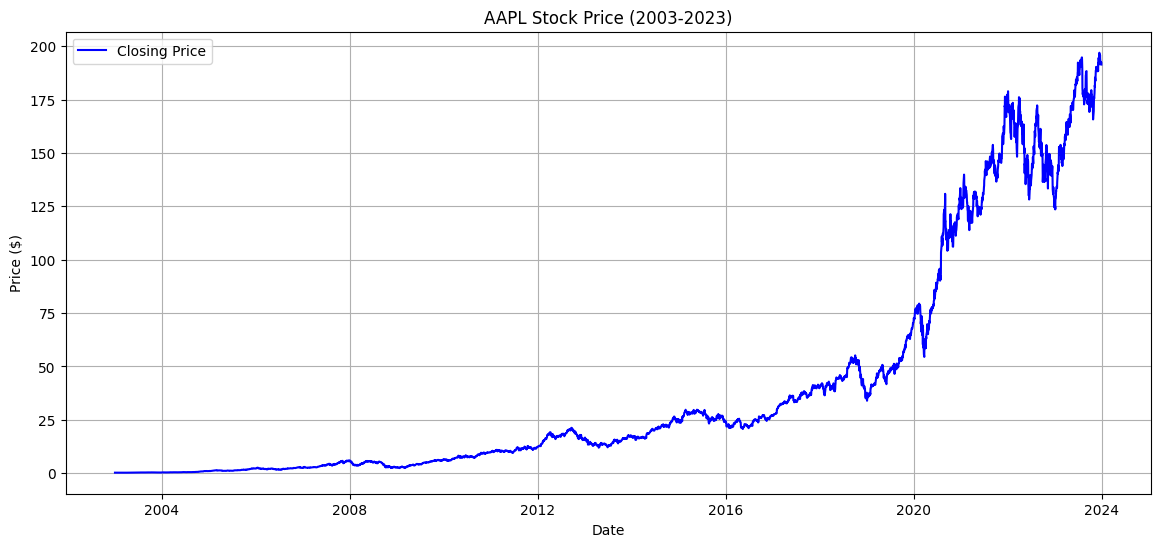

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(stock_data['Close'], label='Closing Price', color='blue')
plt.title(f"{ticker} Stock Price (2003-2023)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Extract 'Close' prices
close_prices = stock_data['Close'].values.reshape(-1, 1)

# Normalize data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

In [ ]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size

train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:, :]

In [ ]:
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape for LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=64,
    initial_epoch=0
)

Epoch 1/500
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 4.7064e-05 - val_loss: 5.9626e-04
Epoch 2/500
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 4.5786e-05 - val_loss: 6.4065e-04
Epoch 3/500
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 4.3432e-05 - val_loss: 9.3767e-04
Epoch 4/500
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 5.6956e-05 - val_loss: 0.0030
Epoch 5/500
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 5.1249e-05 - val_loss: 0.0011
Epoch 6/500
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 4.5244e-05 - val_loss: 0.0021
Epoch 7/500
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 4.4064e-05 - val_loss: 3.5867e-04
Epoch 8/500
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 5.4341e-05 - val_loss: 4.1682e-04
Epoch 9/500
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 4.2513e-05 - val_loss: 0.0010
Epoch 10/500
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 4.6630e-05 - val_loss: 9.9393e-04
Epoch 11/500
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 4.4525e-05 -

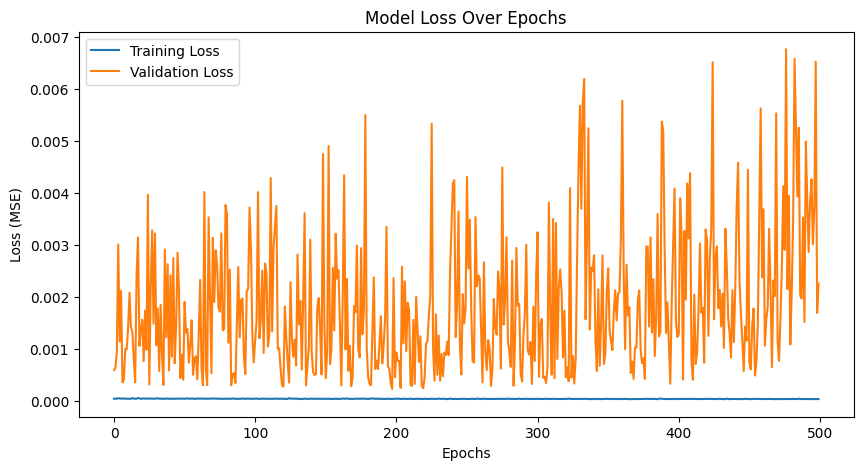

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
mae = mean_absolute_error(y_test_actual, test_predict)
r2 = r2_score(y_test_actual, test_predict)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

RMSE: 9.35
MAE: 7.61
R² Score: 0.92


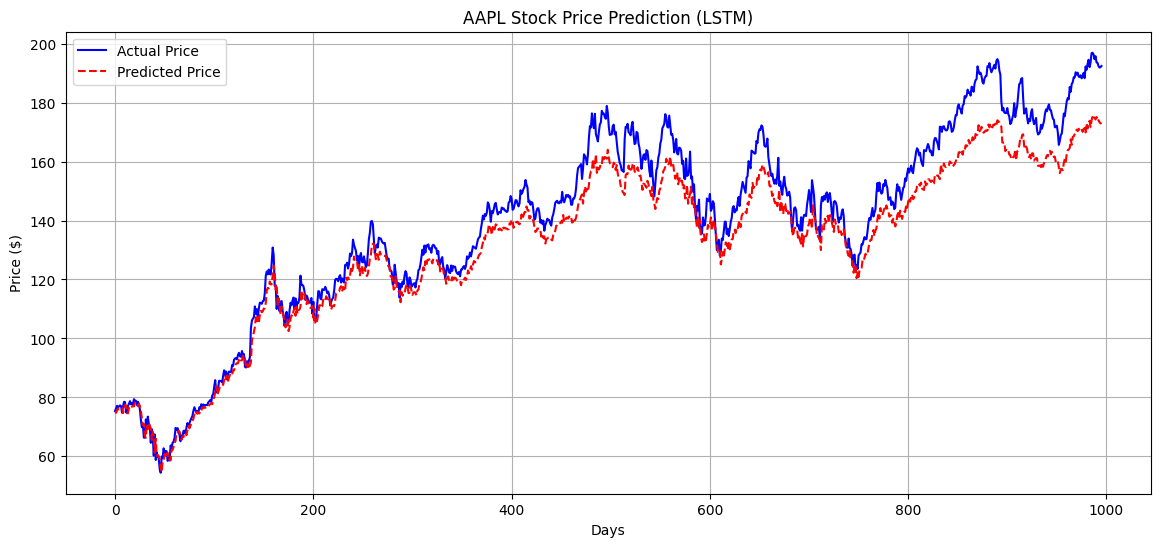

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(test_predict, label='Predicted Price', color='red', linestyle='--')
plt.title(f"{ticker} Stock Price Prediction (LSTM)")
plt.xlabel("Days")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Get the most recent 60 days of data (same as our time_step)
ticker = "AAPL"
new_data = yf.download(ticker, period="60d", interval="1d")

# Extract and preprocess closing prices
latest_prices = new_data['Close'].values.reshape(-1, 1)

# Use the same scaler from training (or refit if unavailable)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(latest_prices)  # Use fit_transform only if scaler wasn't saved

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Reshape into the 3D format LSTM expects: [samples, time steps, features]
input_data = scaled_data.reshape(1, 60, 1)  # 1 sample, 60 time steps, 1 feature

In [ ]:
# Predict the next day's price
predicted_scaled = model.predict(input_data)

# Inverse transform to get actual price
predicted_price = scaler.inverse_transform(predicted_scaled)

print(f"Predicted closing price for tomorrow: ${predicted_price[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted closing price for tomorrow: $210.44


In [ ]:
def predict_future_days(model, last_sequence, days_ahead=5):
    predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(days_ahead):
        # Predict next day
        next_pred = model.predict(current_sequence.reshape(1, 60, 1))

        # Store prediction
        predictions.append(next_pred[0][0])

        # Update sequence (remove oldest, add new prediction)
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred

    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Predict next 5 days
future_predictions = predict_future_days(model, scaled_data)
for i, price in enumerate(future_predictions, 1):
    print(f"Day {i} predicted price: ${price[0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Day 1 predicted price: $210.44
Day 2 predicted price: $211.09
Day 3 predicted price: $212.34
Day 4 predicted price: $212.43
Day 5 predicted price: $212.34


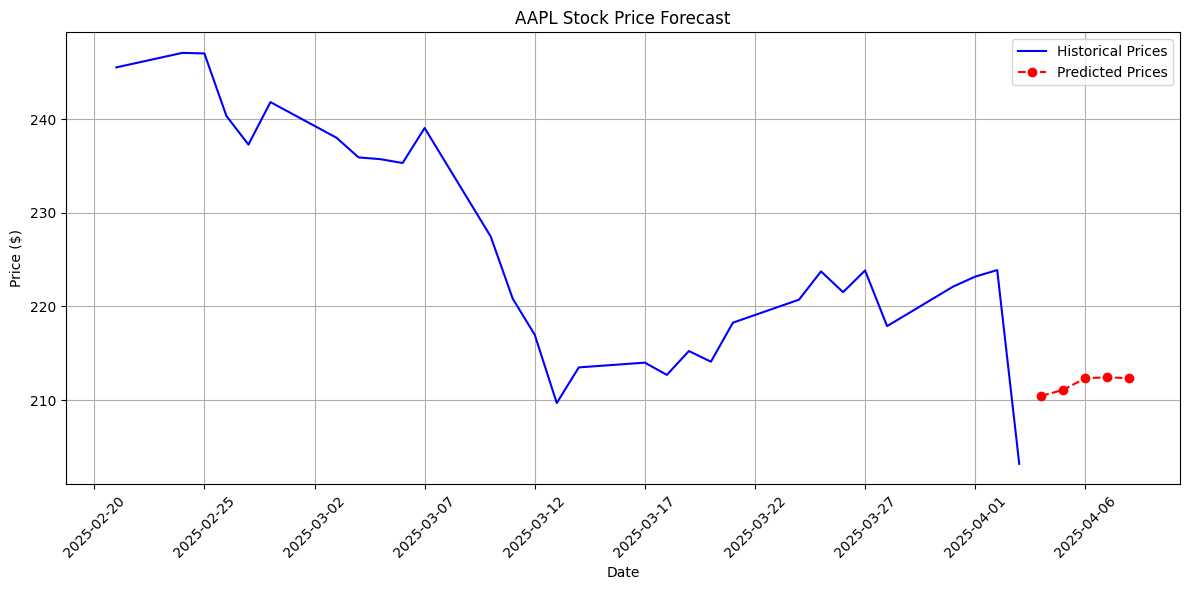

In [ ]:
import matplotlib.dates as mdates

# Get historical dates
historical_dates = new_data.index[-30:]  # Last 30 days for context

# Create future dates
last_date = historical_dates[-1]
future_dates = [last_date + datetime.timedelta(days=x) for x in range(1, 6)]

plt.figure(figsize=(12, 6))
plt.plot(historical_dates, new_data['Close'][-30:], 'b-', label='Historical Prices')
plt.plot(future_dates, future_predictions, 'r--o', label='Predicted Prices')
plt.title(f"{ticker} Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Create a prediction function
def make_prediction(ticker_symbol, days_ahead=1):
    try:
        # Get data
        new_data = yf.download(ticker_symbol, period="60d", interval="1d")

        if len(new_data) < 60:
            raise ValueError("Not enough data points (market closed?)")

        # Preprocess
        latest_prices = new_data['Close'].values.reshape(-1, 1)
        scaled_data = scaler.transform(latest_prices)

        # Make prediction
        if days_ahead == 1:
            predicted = model.predict(scaled_data.reshape(1, 60, 1))
            return scaler.inverse_transform(predicted)[0][0]
        else:
            return predict_future_days(model, scaled_data, days_ahead)

    except Exception as e:
        print(f"Prediction failed: {str(e)}")
        return None

# Example usage:
print(f"Tomorrow's predicted price: ${make_prediction('AAPL'):.2f}")

[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tomorrow's predicted price: $210.44
